In [1]:
!pip install -U PyYAML

In [1]:
#@title Mount your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
%matplotlib inline
%load_ext autoreload
%autoreload 2

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
#@title Link your assignment folder & install requirements
#@markdown Enter the path to the assignment folder in your Google Drive
# If you run this notebook locally or on a cluster (i.e. not on Google Colab)
# you can delete this cell which is specific to Google Colab. You may also
# change the paths for data/logs in Arguments below.
import sys
import os
import shutil
import warnings

folder = "/content/gdrive/MyDrive/MILA/IFT6759/Project/src" #@param {type:"string"}
!ln -Ts "$folder" /content/src 2> /dev/null

# Add the assignment folder to Python path
if '/content/src' not in sys.path:
  sys.path.insert(0, '/content/src')

# Install requirements
#!pip install -qr /content/assignment/requirements.txt

# Check if CUDA is available
import torch
if not torch.cuda.is_available():
  warnings.warn('CUDA is not available.')

In [3]:
import argparse
import logging
import os
import torch
import yaml
import numpy as np
import pickle
import logging
import torch.nn.functional as F


In [4]:
with open('./src/Config/Example.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


In [5]:
device = "cuda"
task = config["task"]
data_file = config["data"]
model_file = config["model"]
augment_file = config["augment"]
augment_strength = config["aug_strength"]
eval_file = config["eval"]
batch_size = config["batch_size"]
learn_rate = config["learning_rate"]
epoch = config["epoch"]
optimizer = config["optimizer"]
momentum = config["momentum"]
weight_decay = config["weight_decay"]
seed = config["seed"]
epoch = config["epoch"]

In [6]:
logging.info(f"==========Dataset: {data_file}==========")
data_file_path = f"Data.{data_file}"
_temp = __import__(name=data_file_path, fromlist=['Data_Load'])
Data_Load = _temp.Data_Load

In [7]:
if augment_file == None:
    print("No augmentation method selected")
else:
    Aug = []
    for i in range(len(augment_file)):
        logging.info(f"==========Augmentation Methods: {augment_file[i]}, with a strength value of {augment_strength[i]}==========")
        augment_file_path = f"Augmentation.{augment_file[i]}"
        _temp = __import__(name=augment_file_path, fromlist=['Aug'])
        Aug.append(_temp.Aug)

In [8]:
# Importing the model class
logging.info(f"==========Model Selected: {model_file}==========")
model_file_path = f"Model.{model_file}"
_temp = __import__(name=model_file_path, fromlist=['ModelClass'])
ModelClass = _temp.ModelClass

In [9]:
# Importing the evaluation methods
logging.info(f"==========Evaluation Method: {eval_file}==========")
eval_file_path = f"Evaluation.{eval_file}"
_temp = __import__(name=eval_file_path, fromlist=['Eval'])
Eval = _temp.Eval  

In [10]:
labelledloader, unlabelledloader, validloader, testloader = Data_Load(task = task, batch_size = batch_size, seed = seed)
logging.info("Dataloader ready")    

Files already downloaded and verified
Files already downloaded and verified


In [11]:
train_tot_accs, valid_tot_accs = [], []
train_tot_losses, valid_tot_losses = [], []

Model = ModelClass(optimizer=optimizer,lr=learn_rate)
Model = Model.to(device=device)

In [12]:
for ep in range(epoch):
    
    # logging.info(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
    print(f"==========Supervised Learning Epoch Number: {ep+1}/{epoch}==========")
    train_accs, valid_accs = [], []
    train_losses, valid_losses = [], []
    
    for idx, batch in enumerate(labelledloader):
        data, target = batch
        data = data.to(device=device)
        labels = F.one_hot(target, num_classes = 10).float().to(device=device)
        acc, loss = Model.train_sup_up(data,labels)
        train_accs.append(acc)
        train_losses.append(loss)
    
    train_tot_accs.append(sum(train_accs)/len(train_accs))
    train_tot_losses.append(sum(train_losses)/len(train_losses))
        
    # logging.info(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")    
    print(f"==========Training Accuracy: {train_tot_accs[-1]:.3f} , Training Loss: {train_tot_losses[-1]:.3f}==========")

    for idx, batch in enumerate(validloader):
        data, target = batch
        data = data.to(device=device)
        labels = F.one_hot(target, num_classes = 10).float().to(device=device)
        acc, loss = Model.evaluation(data,labels)
        valid_accs.append(acc)
        valid_losses.append(loss)
        
    valid_tot_accs.append(sum(valid_accs)/len(valid_accs))
    valid_tot_losses.append(sum(valid_losses)/len(valid_losses))
    
    # logging.info(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")    
    print(f"==========Validation Accuracy: {valid_tot_accs[-1]:.3f} , Validation Loss: {valid_tot_losses[-1]:.3f}==========")

==========Supervised Learning Epoch Number: 1/50==========
==========Training Accuracy: 0.249 , Training Loss: 2.197==========
==========Validation Accuracy: 0.339 , Validation Loss: 2.093==========
==========Supervised Learning Epoch Number: 2/50==========
==========Training Accuracy: 0.452 , Training Loss: 1.492==========
==========Validation Accuracy: 0.487 , Validation Loss: 2.008==========
==========Supervised Learning Epoch Number: 3/50==========
==========Training Accuracy: 0.553 , Training Loss: 1.233==========
==========Validation Accuracy: 0.545 , Validation Loss: 1.977==========
==========Supervised Learning Epoch Number: 4/50==========
==========Training Accuracy: 0.632 , Training Loss: 1.041==========
==========Validation Accuracy: 0.613 , Validation Loss: 1.935==========
==========Supervised Learning Epoch Number: 5/50==========
==========Training Accuracy: 0.677 , Training Loss: 0.908==========
==========Validation Accuracy: 0.653 , Validation Loss: 1.908==========
=====

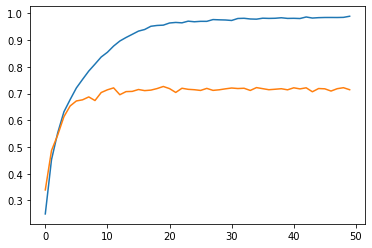

In [13]:
import matplotlib.pyplot as plt
plt.plot(torch.stack(train_tot_accs).cpu().detach().numpy())

plt.plot(torch.stack(valid_tot_accs).cpu().detach().numpy())


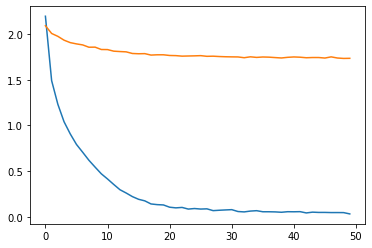

In [14]:

plt.plot(torch.stack(train_tot_losses).cpu().detach().numpy())
plt.plot(torch.stack(valid_tot_losses).cpu().detach().numpy())